In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [41]:
from __future__ import print_function, division

In [3]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
import os
import sys
base_module_path = os.path.abspath(os.path.join('..'))
if base_module_path not in sys.path:
    sys.path.append(base_module_path)
import ama as a

In [7]:
BASE_PATH = '../data/'

In [8]:
df = pd.read_csv(BASE_PATH + 'train_v2.csv'); print(len(df)); df.head()

40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
df['path'] = df['image_name'].map(lambda x: BASE_PATH + 'train-full-jpg/' + x + '.jpg'); df.head()

,image_name,tags,path
0,train_0,haze primary,../data/train-full-jpg/train_0.jpg
1,train_1,agriculture clear primary water,../data/train-full-jpg/train_1.jpg
2,train_2,clear primary,../data/train-full-jpg/train_2.jpg
3,train_3,clear primary,../data/train-full-jpg/train_3.jpg
4,train_4,agriculture clear habitation primary road,../data/train-full-jpg/train_4.jpg


In [10]:
# Build list with unique labels
label_list = []
for tag_str in df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
label_list      

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [11]:
# Add onehot features for every label
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
df.head()

,image_name,tags,path,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,../data/train-full-jpg/train_0.jpg,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,../data/train-full-jpg/train_1.jpg,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,../data/train-full-jpg/train_2.jpg,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,../data/train-full-jpg/train_3.jpg,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,../data/train-full-jpg/train_4.jpg,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [12]:
def check_image(path):
    print(path)
    img = plt.imread(path)
    print(img.shape)
    plt.imshow(img)

../data/train-full-jpg/train_0.jpg
(256, 256, 4)


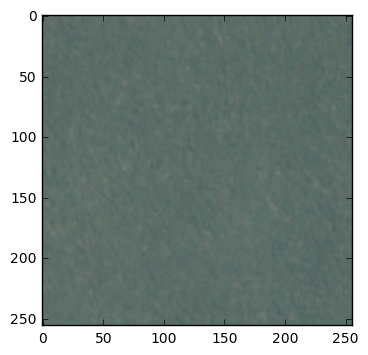

In [13]:
check_image(df.path[0])

In [14]:
### COMPUTE FEATURES ###
from PIL import Image, ImageStat
import scipy
import cv2

def get_features(path):
    st = []
    img = Image.open(path)
    im_stats_ = ImageStat.Stat(img)
    st += im_stats_.sum
    st += im_stats_.mean
    st += im_stats_.rms
    st += im_stats_.var
    st += im_stats_.stddev
    img = np.array(img)[:,:,:3]
    st += [scipy.stats.kurtosis(img[:,:,0].ravel())]
    st += [scipy.stats.kurtosis(img[:,:,1].ravel())]
    st += [scipy.stats.kurtosis(img[:,:,2].ravel())]
    st += [scipy.stats.skew(img[:,:,0].ravel())]
    st += [scipy.stats.skew(img[:,:,1].ravel())]
    st += [scipy.stats.skew(img[:,:,2].ravel())]
    #cv2 jpg
    img = cv2.imread(path)
    bw = cv2.imread(path,0)
    #st += list(cv2.calcHist([bw],[0],None,[256],[0,256]).flatten()) #bw 
    #st += list(cv2.calcHist([img],[0],None,[256],[0,256]).flatten()) #r
    #st += list(cv2.calcHist([img],[1],None,[256],[0,256]).flatten()) #g
    #st += list(cv2.calcHist([img],[2],None,[256],[0,256]).flatten()) #b
    m, s = cv2.meanStdDev(img) #mean and standard deviation
    st += list(list(m))
    st += list(s)
    st += [cv2.Laplacian(bw, cv2.CV_64F).var()] 
    st += [cv2.Laplacian(img, cv2.CV_64F).var()]
    st += [cv2.Sobel(bw,cv2.CV_64F,1,0,ksize=5).var()]
    st += [cv2.Sobel(bw,cv2.CV_64F,0,1,ksize=5).var()]
    st += [cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()]
    st += [cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()]
    st += [(bw<30).sum()]
    st += [(bw>225).sum()]
    return [path, st]

In [15]:
from multiprocessing import Pool, cpu_count
def normalize_img(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_features, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    return fdata

In [16]:
import cPickle as pickle

In [21]:
try:
    x = pickle.load( open(BASE_PATH+ 'features1.pkl', 'rb'))
except:
    x = normalize_img(df['path']); print('train...')

In [73]:
y = df.cloudy
y_mean = y.mean()
print(y.sum())
print(y.mean())
print(len(y))
print(y.sum()/len(y))

2089
0.0516070061019
40479
0.0516070061019


In [24]:
x[:1]

[[10696302.0,
  9545515.0,
  9921551.0,
  0.0,
  163.21261596679688,
  145.6529998779297,
  151.39085388183594,
  0.0,
  163.26825755725224,
  145.68545998184607,
  151.41297981729744,
  0.0,
  18.16591505613178,
  9.45687668188475,
  6.6998180819209665,
  0.0,
  4.262149112376499,
  3.075203518774774,
  2.588400680327713,
  0.0,
  0.8929402158608482,
  0.4680807390767989,
  0.5847271087490951,
  -0.34917909033787253,
  -0.18576165077577272,
  -0.14346481424706475,
  array([ 104.60914612]),
  array([ 110.34700012]),
  array([ 92.78738403]),
  array([ 2.58840068]),
  array([ 3.07520352]),
  array([ 4.26214911]),
  13.106413899920881,
  17.92967671393934,
  19182.654784179293,
  12377.976394161582,
  22976.314172718252,
  15519.153751750375,
  0,
  0]]

In [22]:
with open(BASE_PATH + 'features1.pkl', 'wb') as output:
    #pickle.dump(x, output)

In [26]:
import xgboost as xgb
### TRAIN XGBOOST ###
dtrain = xgb.DMatrix(x, y)

(40479,)

#### Versions, changes, results
1. 'objective' : 'binary:logistic', 'eval_metric':'error@0.9', 'eta':1
    * Initial set up
    * Unsure about best objective or even eval metric
    * Result: step156, test0.022409, train0.0
2. 'eval_metric':'error@0.1'
    * just trying
    * Result: step77, test0.024509, train0.000019
3. 'eval_metric':'error@0.9', 'eta':0.03
    * make training slower
    * Result: step01, didn't train
4. 'eta':0.3
    * faster trianing
    * didnt bottom out test before end of run
    * Result: step349, test0.023545, train0.0
5. 'base_score':y_mean,
    * better init
    * faster trianing
    * Result: step349, test0.023323, train0.000006
6. 'eta':1
    * faster
    * Result: step2, test0.027177, train0.023441
7. 'max_depth':3,
    * reduce over fitting
    * Result: step

In [81]:
params = {
    'objective' : 'binary:logistic', # this outputs probability to be a 1
    'eval_metric':'error@0.9', # error with 0.9 threshold prob
    'eta':1, #learning rate, default 0.3
    'base_score':y_mean,
    'max_depth':3,
    #'subsample':0.5,
    #'colsample_bytree':0.5,
    #'gamma':0,
    #'min_child_weight':6,
    #'alpha':1,
}

In [82]:
cv_result = xgb.cv(params, dtrain, 
                   nfold=5, 
                   num_boost_round=350, 
                   early_stopping_rounds=50, 
                   verbose_eval=10, 
                   show_stdv=False)

[0]	train-error@0.9:0.030661	test-error@0.9:0.0318222
[10]	train-error@0.9:0.0342928	test-error@0.9:0.0357256
[20]	train-error@0.9:0.0308892	test-error@0.9:0.033082
[30]	train-error@0.9:0.0285732	test-error@0.9:0.0310808
[40]	train-error@0.9:0.0277826	test-error@0.9:0.0321432
[50]	train-error@0.9:0.0252008	test-error@0.9:0.0298704
[60]	train-error@0.9:0.0234776	test-error@0.9:0.029302
[70]	train-error@0.9:0.022446	test-error@0.9:0.0297222
[80]	train-error@0.9:0.0213898	test-error@0.9:0.0294008
[90]	train-error@0.9:0.0202902	test-error@0.9:0.029154
[100]	train-error@0.9:0.0190984	test-error@0.9:0.0288822
[110]	train-error@0.9:0.0181902	test-error@0.9:0.0287338
[120]	train-error@0.9:0.0175726	test-error@0.9:0.0287338
[130]	train-error@0.9:0.0167882	test-error@0.9:0.0286596
[140]	train-error@0.9:0.0161336	test-error@0.9:0.0287338
[150]	train-error@0.9:0.015627	test-error@0.9:0.0288326
[160]	train-error@0.9:0.0148362	test-error@0.9:0.0291292


In [83]:
cv_result.tail()

,test-error@0.9-mean,test-error@0.9-std,train-error@0.9-mean,train-error@0.9-std
109,0.028808,0.001244,0.018548,0.001959
110,0.028734,0.001134,0.018190,0.002042
111,0.028684,0.001023,0.018147,0.001966
112,0.028511,0.000919,0.018153,0.002055
113,0.028289,0.000781,0.018141,0.002071


In [46]:
model = xgb.train(dict(params), dtrain, num_boost_round=len(cv_result), 
                  evals=[(dtrain, 'eval')])

[0]	eval-error@0.9:0.051607
[1]	eval-error@0.9:0.032511
[2]	eval-error@0.9:0.030213
[3]	eval-error@0.9:0.028879
[4]	eval-error@0.9:0.028706
[5]	eval-error@0.9:0.027743
[6]	eval-error@0.9:0.024902
[7]	eval-error@0.9:0.025371
[8]	eval-error@0.9:0.024754
[9]	eval-error@0.9:0.022135
[10]	eval-error@0.9:0.021913
[11]	eval-error@0.9:0.021517
[12]	eval-error@0.9:0.020084
[13]	eval-error@0.9:0.019615
[14]	eval-error@0.9:0.019096
[15]	eval-error@0.9:0.018182
[16]	eval-error@0.9:0.017293
[17]	eval-error@0.9:0.016947
[18]	eval-error@0.9:0.01628
[19]	eval-error@0.9:0.015712
[20]	eval-error@0.9:0.014823
[21]	eval-error@0.9:0.014526
[22]	eval-error@0.9:0.014007
[23]	eval-error@0.9:0.013266
[24]	eval-error@0.9:0.012945
[25]	eval-error@0.9:0.012179
[26]	eval-error@0.9:0.011982
[27]	eval-error@0.9:0.011043
[28]	eval-error@0.9:0.011216
[29]	eval-error@0.9:0.01082
[30]	eval-error@0.9:0.010722
[31]	eval-error@0.9:0.0104
[32]	eval-error@0.9:0.009635
[33]	eval-error@0.9:0.009289
[34]	eval-error@0.9:0.008819

In [47]:
pred = model.predict(dtrain)

In [50]:
np.where(pred >0.5)

(array([   12,    14,    26, ..., 40447, 40461, 40475]),)

In [56]:
len(np.where(pred > 0.5)[0])

2089

In [57]:
np.take(pred, np.where(pred >0.5))

array([[ 0.98783582,  0.99526775,  0.98916936, ...,  0.99984324,
         0.9960736 ,  0.99347562]], dtype=float32)

In [52]:
len(df[df.cloudy == 1])

2089